In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import random
import os

In [2]:
# 乱数シードの固定（再現性の確保）
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

fix_seed(42) # シードを42に固定

# デバイスの設定 (GPUが使えるならGPUを使う)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


# 1. データ読込 (MNIST)

In [3]:
# 前処理の定義
# ToTensor: 画像をPyTorchのTensor(0-1の範囲)に変換
# Normalize: 正規化 (平均0.5, 標準偏差0.5) -> -1から1の範囲にする
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練データのダウンロードとロード
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# テストデータのダウンロードとロード
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# DataLoaderの作成
batch_size = 64
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=1000, 
    shuffle=False # テストデータはシャッフルしない（順序固定）
)

print(f"訓練データ数: {len(train_dataset)}")
print(f"テストデータ数: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.43MB/s]

訓練データ数: 60000
テストデータ数: 10000


## データの確認

In [4]:
examples = iter(test_loader)
example_data, example_targets = next(examples)
i = 0
print(f"Label: {example_targets[i].item()}")
print("size", example_data[i][0].shape)
print(example_data[i][0][14])

Label: 7
size torch.Size([28, 28])
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.5373,  0.9529,  0.9922, -0.5137, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000])


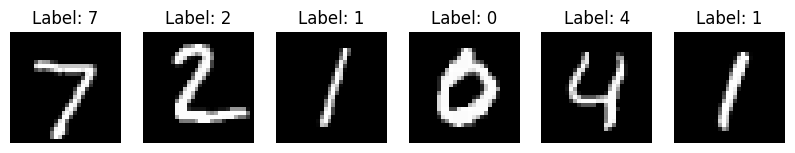

In [5]:
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    # (Channel, Height, Width) -> (Height, Width) に変形して表示
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.show()

# 2. モデルの定義

## モデルA: Simple MLP (多層パーセプトロン)
- 画像の空間情報を無視して、1列に並べた画素値として処理
- 構造上、画像の位置関係（隣り合うピクセルの情報など）を捉えるのが苦手

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # 28x28の画像を1列(784次元)に平坦化
        self.flatten = nn.Flatten()
        # 全結合層
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10) # 出力は0-9の10クラス

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## モデルB: Simple CNN (畳み込みニューラルネットワーク)
- 「畳み込み層」で画像の空間的な特徴（線、形、テクスチャなど）を抽出します。
- 画像認識において圧倒的に高い性能を発揮します。

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 特徴抽出部 (畳み込み)
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 画像サイズを半分にする 28x28 -> 14x14
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 分類部 (全結合)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 3. 学習と評価の関数化
両方のモデルで共通して使う学習ループを関数にします

In [8]:
def train_and_evaluate(model, model_name, train_loader_fn, test_loader_fn, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\n=== {model_name} の学習開始 ===")
    
    # 学習ループ
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader_fn:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader_fn)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # 評価ループ
    print(f"--- {model_name} の評価 ---")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader_fn:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"テスト正解率: {accuracy:.4f}")
    
    return loss_history, accuracy, all_preds, all_labels

# 4. 実行と主要モデルの比較

In [9]:
EPOCHS = 5

In [10]:
# --- MLPの学習 ---
mlp_model = SimpleMLP()
mlp_loss, mlp_acc, mlp_preds, y_true = train_and_evaluate(
    mlp_model, "MLP", train_loader, test_loader, EPOCHS
)


=== MLP の学習開始 ===
Epoch [1/5], Loss: 0.3160
Epoch [2/5], Loss: 0.1434
Epoch [3/5], Loss: 0.1054
Epoch [4/5], Loss: 0.0886
Epoch [5/5], Loss: 0.0741
--- MLP の評価 ---
テスト正解率: 0.9668


In [11]:
# --- CNNの学習 ---
cnn_model = SimpleCNN()
cnn_loss, cnn_acc, cnn_preds, _ = train_and_evaluate(
    cnn_model, "CNN", train_loader, test_loader, EPOCHS
)


=== CNN の学習開始 ===
Epoch [1/5], Loss: 0.2283
Epoch [2/5], Loss: 0.0604
Epoch [3/5], Loss: 0.0431
Epoch [4/5], Loss: 0.0323
Epoch [5/5], Loss: 0.0265
--- CNN の評価 ---
テスト正解率: 0.9871


# 5. 結果の可視化と考察

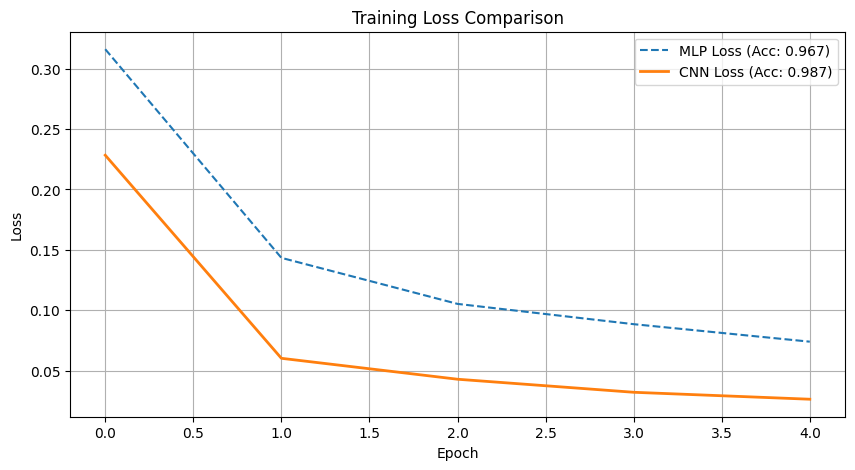

In [12]:
# 損失の推移を比較
plt.figure(figsize=(10, 5))
plt.plot(mlp_loss, label=f'MLP Loss (Acc: {mlp_acc:.3f})', linestyle='--')
plt.plot(cnn_loss, label=f'CNN Loss (Acc: {cnn_acc:.3f})', linewidth=2)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


MLPが間違えてCNNが正解した画像の枚数: 268
--- 改善例の可視化 (上:画像, 下:MLP予測/CNN予測/正解) ---


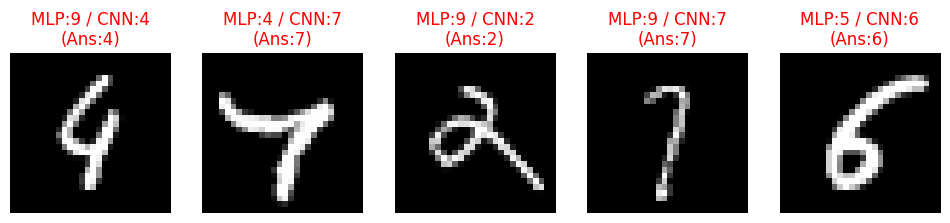

In [13]:
# MLPが間違えて、CNNが正解したものを探す
diff_indices = [i for i in range(len(y_true)) if mlp_preds[i] != y_true[i] and cnn_preds[i] == y_true[i]]
print(f"\nMLPが間違えてCNNが正解した画像の枚数: {len(diff_indices)}")

if len(diff_indices) > 0:
    print("--- 改善例の可視化 (上:画像, 下:MLP予測/CNN予測/正解) ---")
    plt.figure(figsize=(12, 4))
    # 最初の5枚を表示
    for i, idx in enumerate(diff_indices[:5]):
        image = test_dataset[idx][0] # Tensor
        label = y_true[idx]
        
        plt.subplot(1, 5, i+1)
        plt.imshow(image[0], cmap='gray')
        plt.title(f"MLP:{mlp_preds[idx]} / CNN:{cnn_preds[idx]}\n(Ans:{label})", color='red')
        plt.axis('off')
    plt.show()

# 6. CNNの内部解析: フィルターと特徴マップの可視化

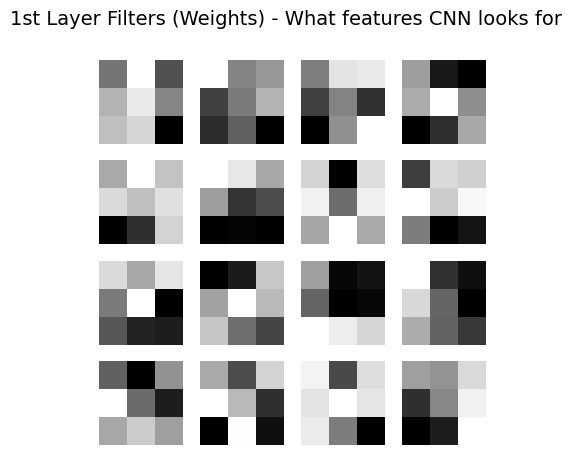

In [14]:
# --- 1. 第1層のフィルタ（重み）の可視化 ---
first_layer_weights = cnn_model.features[0].weight.data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.suptitle('1st Layer Filters (Weights) - What features CNN looks for', fontsize=14)
for i in range(16): # 32個のフィルタすべてを表示
    plt.subplot(4, 4, i+1)
    # 3x3のフィルターを表示
    plt.imshow(first_layer_weights[i, 0], cmap='gray') 
    plt.axis('off')
plt.show()

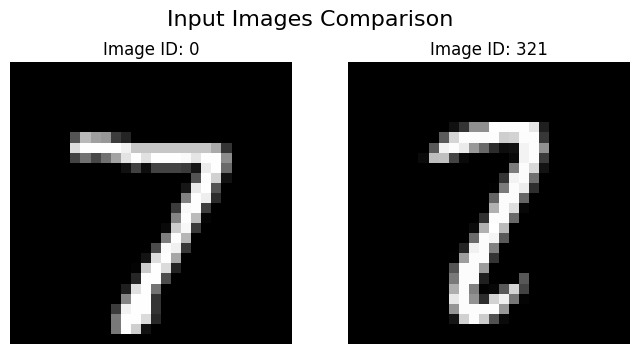


--- Layer 1 Feature Maps (32 channels) ---


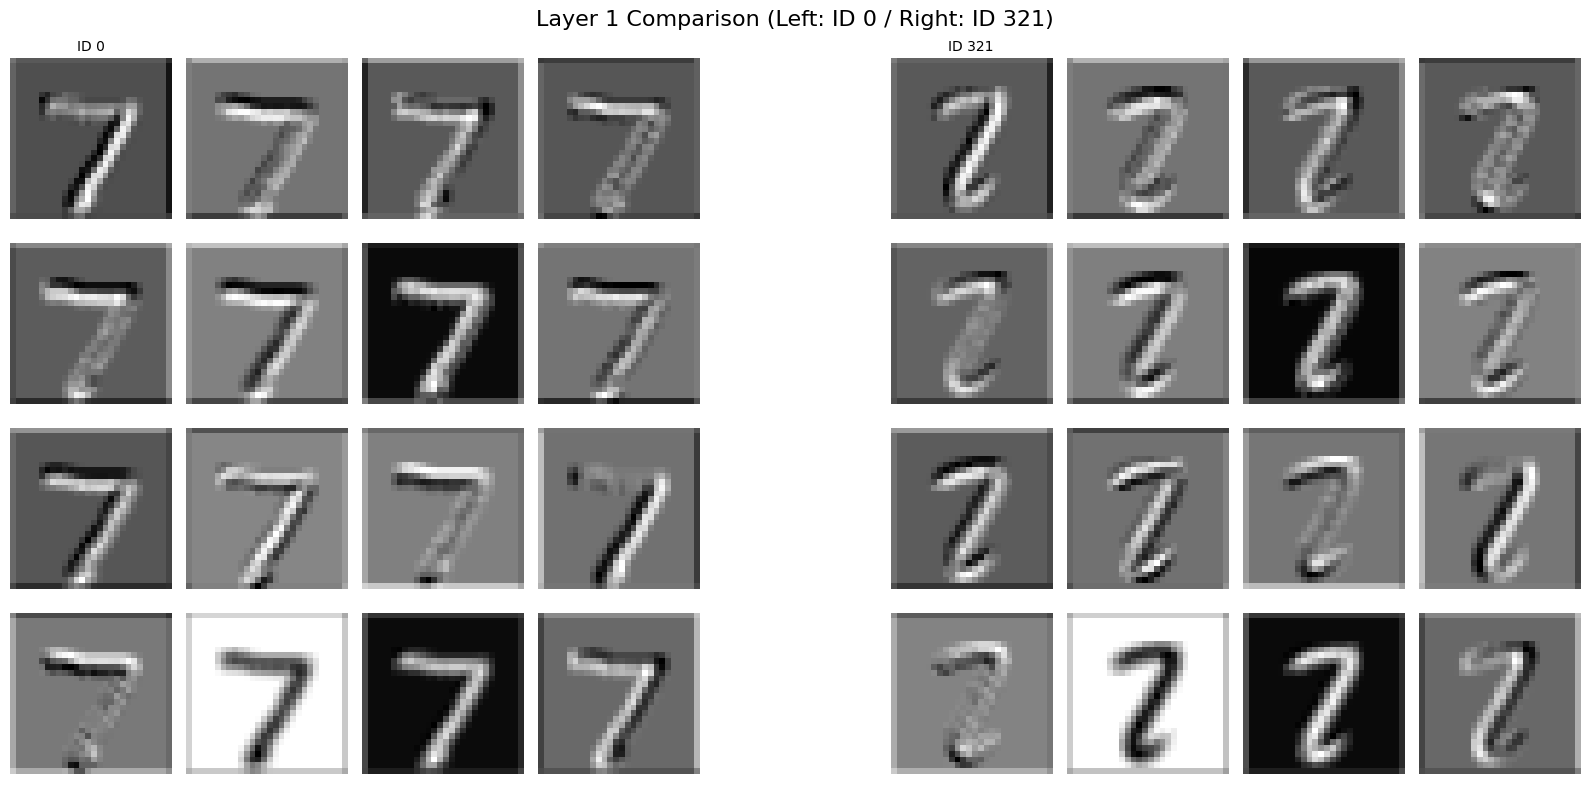

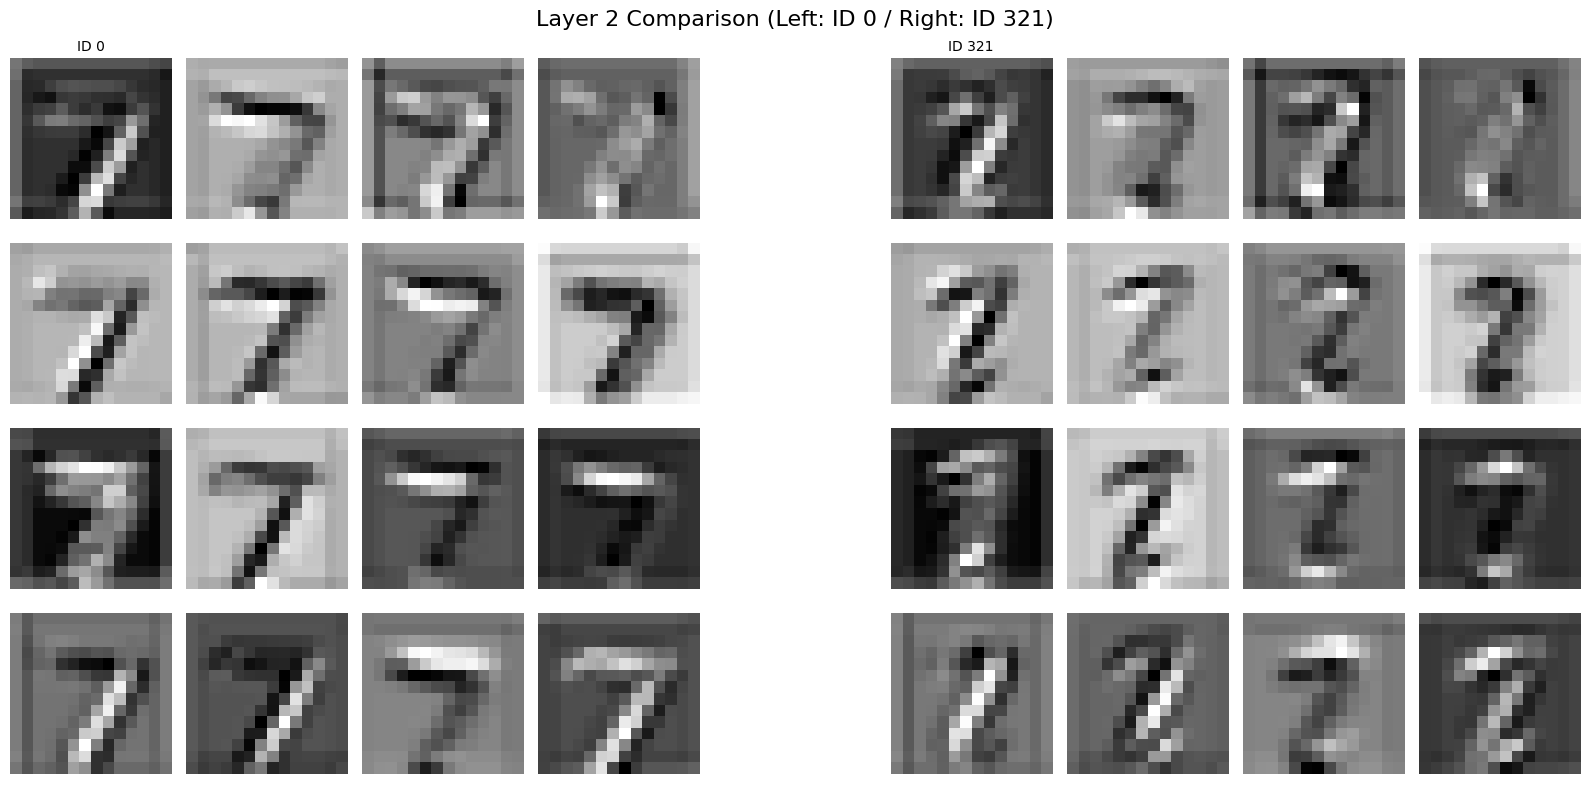

In [15]:
# --- 2. 特徴マップ（Feature Maps）の可視化 ---

target_indices = [y_true.index(7), 321]
results = [] # ここに2つの画像の結果を格納します

# 1. データの取得と推論
for i in target_indices:
    # 画像取得
    sample_image, _ = test_dataset[i]
    input_tensor = sample_image.unsqueeze(0).to(device)
    
    # 各層の出力を取得
    feature_maps = []
    x = input_tensor
    for layer in cnn_model.features:
        x = layer(x)
        feature_maps.append(x)
    
    # 結果を辞書としてリストに保存
    results.append({
        "id": i,
        "input": sample_image[0],
        "layer1": feature_maps[0].cpu().detach().numpy(), # 第1層 (32ch)
        "layer2": feature_maps[3].cpu().detach().numpy()  # 第2層 (64ch)
    })

# (1) 元画像の比較
plt.figure(figsize=(8, 4))
plt.suptitle("Input Images Comparison", fontsize=16)

for idx, res in enumerate(results):
    plt.subplot(1, 2, idx + 1)
    plt.title(f"Image ID: {res['id']}")
    plt.imshow(res['input'], cmap='gray')
    plt.axis('off')
plt.show()

# (2) Layer 1 の特徴マップ比較
print("\n--- Layer 1 Feature Maps (32 channels) ---")
fig, axes = plt.subplots(4, 9, figsize=(16, 8))
fig.suptitle('Layer 1 Comparison (Left: ID 0 / Right: ID 321)', fontsize=16)

for i in range(16):
    row = i // 4
    col = i % 4
    
    # 左側 (ID 0)
    axes[row, col].imshow(results[0]['layer1'][0, i], cmap='gray')
    axes[row, col].axis('off')
    if i == 0: axes[row, col].set_title("ID 0", fontsize=10)\

    # 右側 (ID 321)
    axes[row, col + 5].imshow(results[1]['layer1'][0, i], cmap='gray')
    axes[row, col + 5].axis('off')
    axes[row, 4].axis('off')
    if i == 0: axes[row, col + 5].set_title("ID 321", fontsize=10)

plt.tight_layout()
plt.show()

# (3) Layer 2 の特徴マップ比較
fig, axes = plt.subplots(4, 9, figsize=(16, 8))
fig.suptitle('Layer 2 Comparison (Left: ID 0 / Right: ID 321)', fontsize=16)

for i in range(16):
    row = i // 4
    col = i % 4
    
    # 左側 (ID 0)
    axes[row, col].imshow(results[0]['layer2'][0, i], cmap='gray')
    axes[row, col].axis('off')
    if i == 0: axes[row, col].set_title("ID 0", fontsize=10)

    # 右側 (ID 321)
    axes[row, col + 5].imshow(results[1]['layer2'][0, i], cmap='gray')
    axes[row, col + 5].axis('off')
    axes[row, 4].axis('off')
    if i == 0: axes[row, col + 5].set_title("ID 321", fontsize=10)
    
plt.tight_layout()
plt.show()

### 練習問題
- **問題** MLエンジニアであるあなたに、ECサイト運営を行うお客様から次の問合せがきました。業務適用可能なファッション画像分類AIを開発してください。
> ECサイトの商品登録において、現在は担当者が手動でカテゴリを設定しており、誤分類による検索精度の低下や作業工数の増大が課題となっています。<br>
商品の写真をアップロードするだけで「Tシャツ」「スニーカー」「バッグ」などのカテゴリを自動推定する仕組みをAIで構築したいと考えています。<br>
タグ付け作業の大幅削減と、一貫した分類による検索精度向上が目的です。<br>
この機能の開発をご検討いただけますでしょうか。
- **商品分類タグ**
    - 0: T-Shirt → Tシャツ
    - 1: Trouser → ズボン（パンツ）
    - 2: Pullover → プルオーバー（頭からかぶって着るセーター類）
    - 3: Dress → ワンピース
    - 4: Coat → コート
    - 5: Sandal → サンダル
    - 6: Shirt → シャツ（襟つきの一般的なシャツ）
    - 7: Sneaker → スニーカー
    - 8: Bag → バッグ
    - 9: Ankle Boot → アンクルブーツ（くるぶし丈のブーツ）
- **評価指標**：正解率
    - **92~95%**：実務でのPoCレベルとしては十分
    - **96~98%**：かなり優秀なモデル、ここまで出れば精度としてはほぼ上限に近い
    - **99%以上**：実務では過剰性能（Overkill）のレベル、作ってみろ

- **チャット報告フォーマット**
```
--- 評価結果 ---
施策: CNNの層を1つ追加
テスト正解率 (Accuracy): 0.9193
```

### 参考
ここから実行し始めても動きます

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import random
import os

In [17]:
# 乱数シードの固定（再現性の確保）
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

fix_seed(42) # シードを42に固定

# デバイスの設定 (GPUが使えるならGPUを使う)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


In [18]:
# Fashion-MNISTデータのロード
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_fmnist = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
test_fmnist = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# DataLoaderの作成
train_loader_f = DataLoader(
    dataset=train_fmnist, 
    batch_size=64, 
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)

test_loader_f = DataLoader(
    dataset=test_fmnist, 
    batch_size=1000, 
    shuffle=False
)

# ラベルの定義
fashion_labels = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.5MB/s]


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 特徴抽出部 (畳み込み)
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 画像サイズを半分にする 28x28 -> 14x14
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 分類部 (全結合)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:
def train_and_evaluate(model, model_name, train_loader_fn, test_loader_fn, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\n=== {model_name} の学習開始 ===")
    
    # 学習ループ
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader_fn:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader_fn)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # 評価ループ
    print(f"--- {model_name} の評価 ---")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader_fn:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"テスト正解率: {accuracy:.4f}")
    
    return loss_history, accuracy, all_preds, all_labels

In [21]:
model = SimpleCNN()

f_loss, f_acc, f_preds, f_true = train_and_evaluate(
    model, 
    "CNN", 
    train_loader_f, 
    test_loader_f, 
    num_epochs=5
)


=== CNN の学習開始 ===
Epoch [1/5], Loss: 0.5024
Epoch [2/5], Loss: 0.3318
Epoch [3/5], Loss: 0.2897
Epoch [4/5], Loss: 0.2584
Epoch [5/5], Loss: 0.2393
--- CNN の評価 ---
テスト正解率: 0.9039


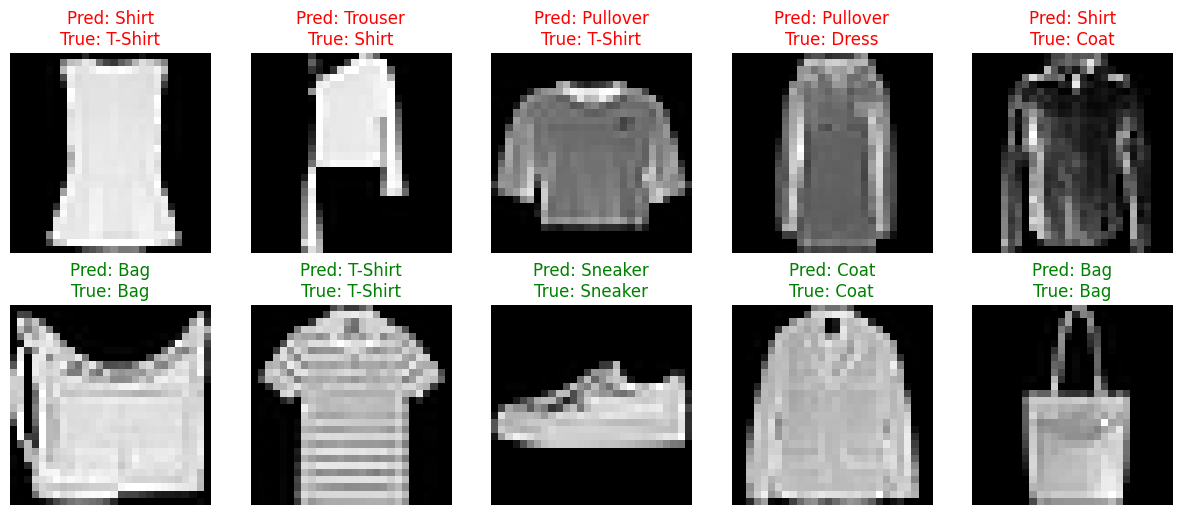

In [22]:
plt.figure(figsize=(15, 6))

# 正解と不正解のインデックスを抽出
correct_indices = [i for i in range(len(test_fmnist)) if f_preds[i] == f_true[i]]
incorrect_indices = [i for i in range(len(test_fmnist)) if f_preds[i] != f_true[i]]

# 表示する数
n_samples = 10
n_incorrect = min(len(incorrect_indices), 5) # 間違いを最大5個まで
n_correct = n_samples - n_incorrect

# ランダムに抽出
sample_indices = []
if n_incorrect > 0:
    sample_indices.extend(np.random.choice(incorrect_indices, n_incorrect, replace=False))
if n_correct > 0:
    sample_indices.extend(np.random.choice(correct_indices, n_correct, replace=False))

for i, idx in enumerate(sample_indices):
    image = test_fmnist[idx][0]
    true_label = f_true[idx]
    pred_label = f_preds[idx]
    color = 'green' if true_label == pred_label else 'red'
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Pred: {fashion_labels[pred_label]}\nTrue: {fashion_labels[true_label]}", color=color)
    plt.axis('off')
plt.show()